In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from gee_scripts.parameters import explain_vars
from gee_scripts.models import get_random_forest
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
from gee_scripts.plots import plot_observed_vs_predicted


Earth Engine initialized successfully, with ee-dfgm2006


2024-07-15 22:02:36.239464: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 22:02:36.242378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 22:02:36.312644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-15 22:02:36.313655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 22:02:37.723943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## 1. Read cross validation results

In [3]:
results_df = pd.read_csv('data/13_estimation_results/kalimantan_multiple_models_cross_validation_results_sorted.csv')

# Remove results from linear model (we already know that gwl is not linear)
results_df = results_df[results_df['estimator_name'] != 'LinearRegression']
len(results_df)

1575

In [4]:
# dont use e notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()
summary_stats



,r2_score,rmse,pearson_r
count,1575.00000,1575.00000,1575.00000
mean,-33.27218,46.48036,0.52238
std,692.94149,107.99740,0.32150
min,-17857.92928,4.58459,-0.57184
25%,-0.31815,10.37976,0.33055
50%,0.13852,17.01259,0.58012
75%,0.52655,44.07612,0.77091
max,0.98417,1878.66707,0.99319


In [5]:
# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()
model_performance

,r2_score,rmse,pearson_r
estimator_name,,,
GradientBoostingRegressor,-1.62263,35.12224,0.57706
RandomForestRegressor,-0.97798,34.90485,0.58112
Sequential,-97.21594,69.41398,0.40898


In [6]:
# Analyze performance by split type
split_performance = results_df.groupby('validation')[['r2_score', 'rmse', 'pearson_r']].mean()
split_performance


,r2_score,rmse,pearson_r
validation,,,
cross validation index,0.45644,25.86423,0.70754
cross validation month,0.14117,28.91311,0.59198
cross validation station,-113.16950,78.37044,0.45712
cross validation year,-1.01667,46.32816,0.32422


In [7]:
# Calculating mean R2 and RMSE for each PHU
phu_split_performance = results_df.groupby(['phu_id', 'validation']).agg({
    'pearson_r': 'mean',
    'r2_score': 'mean',
    'rmse': 'mean',
    'no_obs': 'mean'  # Total number of observations for each PHU
}).reset_index()
# Sort by R2 score
phu_split_performance.sort_values(by='r2_score', ascending=False, inplace=True)
# don't show the exponential notation
pd.options.display.float_format = '{:.4f}'.format
phu_split_performance


,phu_id,validation,pearson_r,r2_score,rmse,no_obs
24,350.0000,cross validation index,0.8897,0.7852,15.4548,358.0000
28,351.0000,cross validation index,0.8891,0.7827,19.5595,982.0000
32,352.0000,cross validation index,0.8859,0.7771,43.7622,276.0000
11,297.0000,cross validation month,0.8840,0.7473,12.2139,159.0000
36,357.0000,cross validation index,0.8866,0.7416,25.1031,141.0000
10,297.0000,cross validation index,0.8836,0.7333,11.8218,159.0000
25,350.0000,cross validation month,0.8671,0.7217,15.3243,358.0000
29,351.0000,cross validation month,0.8475,0.7113,19.7213,982.0000
37,357.0000,cross validation month,0.8915,0.6623,25.5570,141.0000
33,352.0000,cross validation month,0.8025,0.6036,69.1618,276.0000


In [8]:
# Calculating mean R2 and RMSE for each PHU
df_filter = (~results_df.estimator_name.isin(["Sequential"]))
phu_split_performance = results_df[df_filter].groupby(['phu_id']).agg({
    'pearson_r': 'median',
    'r2_score': 'median',
    'rmse': 'median',
    'no_obs': 'median'  # Total number of observations for each PHU
}).reset_index()
# Sort by R2 score
phu_split_performance.sort_values(by='r2_score', ascending=False, inplace=True)
# don't show the exponential notation
pd.options.display.float_format = '{:.4f}'.format
phu_split_performance.head()

phu_split_performance

,phu_id,pearson_r,r2_score,rmse,no_obs
10,357.0000,0.8714,0.7221,25.9353,141.0000
3,297.0000,0.8589,0.7085,11.9431,159.0000
7,350.0000,0.8175,0.6368,18.2327,358.0000
8,351.0000,0.8275,0.5904,20.3139,982.0000
9,352.0000,0.7637,0.5442,27.1283,276.0000
13,379.0000,0.8121,0.4856,30.8998,65.0000
2,256.0000,0.6371,0.3317,6.7224,849.0000
16,407.0000,0.6135,0.2880,8.9380,200.0000
6,340.0000,0.5562,0.2176,6.7044,1546.0000
11,371.0000,0.5064,0.1793,12.5354,280.0000


In [9]:
best_phus = phu_split_performance.head(5).phu_id.values
best_phus

array([357., 297., 350., 351., 352.])

# 2. Train the model

In [27]:
# USER PARAMETERS

# Select the region where to work
region = "kalimantan"

## List of specific id values to remove
# These stations were selected based on the results of the previous analysis
bad_stations = ['batok1','batok2','brg11','brg13','brg16','BRG_620309_01','BRG_620309_02','BRG_630805_01','BRG_630708_01']


In [28]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
assert len(df) == 32783, "The length of the dataframe is not correct"
data = df[(~df.id.isin(bad_stations)) & (df.phu_id.isin(best_phus))].copy()
print(len(data))

1916


### 2.1 Hyperparameter tuning

Hyperparameter tuning is the process of finding the best settings for a model's hyperparameters to improve its performance. For a RandomForestRegressor, this means adjusting parameters like the number of trees, maximum depth, and minimum samples split to achieve the best accuracy and generalization. 

In [19]:
# Create a grid search to find the best parameters for the random forest model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)

X_train = data[explain_vars]
y_train = data['gwl_cm']

grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

### 2.2. Model accuracy

In [20]:
from gee_scripts.models import bootstrap

In [22]:
bootrap_result = bootstrap(
    df = data[data.gwl_cm>-150], 
    variable = "gwl_cm", 
    iterations = 25, 
    train_size = 0.8, 
    bootstrap_by=["observations"],
    best_params = {
        'max_depth': 20,
        'min_samples_leaf': 2,
        'min_samples_split': 10,
        'n_estimators': 300
    }
)
bootrap_result

Training with 1883 observations


,mean,min,max,median
r,0.8912,0.8703,0.9101,0.8896
r2,0.7879,0.7488,0.8218,0.7872
rmse,17.8871,15.8713,19.9723,17.8081
samples_train,1506.0000,1506.0000,1506.0000,NaN
samples_test,377.0000,377.0000,377.0000,NaN


### 2.3. Model testing

lenght of train and test 1242 662
r2_score: 0.4330725135207132
rmse: 24.065275551896093
pearson r: 0.7120090203441073
p-value: 1.9539368345763444e-103
Train months: [4, 5, 6, 7, 8, 9, 10, 11, 12]
Test months: [1, 2, 3]


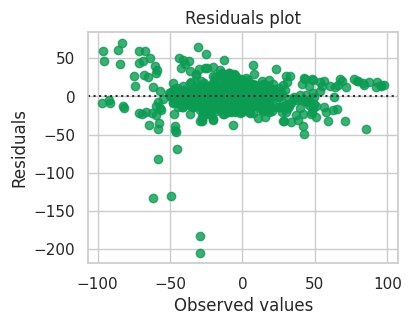

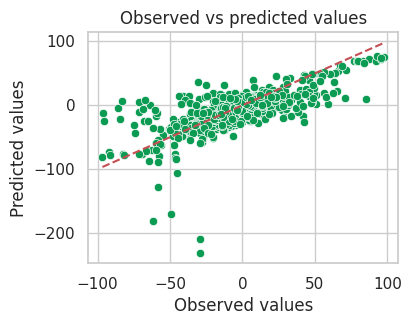

In [29]:
test_months = [1,2,3]
train_months = [m for m in range(1,13) if m not in test_months]

train_data = data[data["date"].dt.month.isin(train_months)]
test_data = data[(data["date"].dt.month.isin(test_months)) & (data.gwl_cm>-150)]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

# print train and test months
print(f"Train months: {train_months}")
print(f"Test months: {test_months}")
plot_observed_vs_predicted(y_test, y_pred_test, color = 1)

lenght of train and test 1397 140
r2_score: 0.3435072605494818
rmse: 41.58771991203835
pearson r: 0.6097731100568111
p-value: 1.2841040255445891e-15


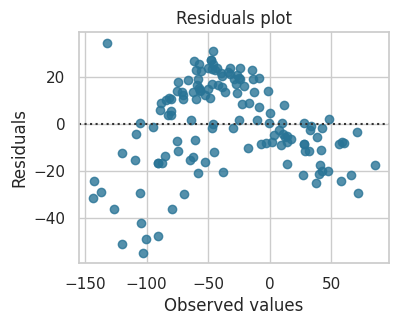

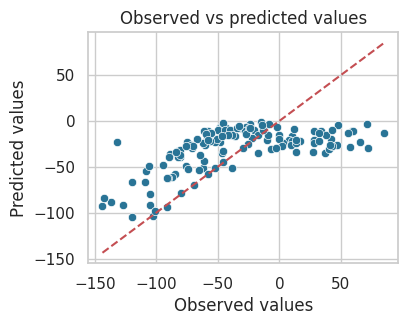

In [31]:
# divide test/train by random sampling

# randomly select 80% as train and the rest as test

# train_data = data[data.gwl_cm>-150].sample(frac=0.8)
# test_data = data[data.gwl_cm>-150].drop(train_data.index)

# best_kalimantan_phus = [357., 297., 350., 351., 352.]

# Create a new feature that indicates if an area is flooded or not

train_data = df[
    (df.gwl_cm>-150)
    # & (df.gwl_cm<5) 
    & (df.phu_id.isin([350, 351, 379, ])) 
    & (~df.id.isin(bad_stations))
]

test_data = df[
    (df.gwl_cm>-150) 
    # & (df.gwl_cm<5) 
    & (df.phu_id.isin([357]))
    &(~df.id.isin(bad_stations))
]

# test_data = df[
#     (df.id == "BRG_630801_01") & (df.gwl_cm>-150)
# ]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")


plot_observed_vs_predicted(y_test, y_pred_test, color=0)